<a href="https://colab.research.google.com/github/Prakrut/Fraud_Detection/blob/master/Code/CreditCardFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Python
import pandas as pd
import sys, os
import numpy as np 
import time
path = '/content/drive/My Drive/ieee-fraud-detection'
os.chdir(path)
import gc

# Third-Party
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import multiprocessing

# Custom
from utility import piechart, barchart_categorical, barchart_continuous

# Options
pd.set_option('max_columns',500)
pd.set_option('max_rows',50)


# Data

In [3]:
#path = '../Data'
#for i in os.listdir(path):
#    print (i)

In [5]:
%%time
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
train = train_transaction.merge(train_identity,
                                on = 'TransactionID',
                                how = 'left'
                               )
test = pd.merge(pd.read_csv('test_transaction.csv'),
                pd.read_csv('test_identity.csv'),
                on = 'TransactionID',
                how = 'left'
               )

CPU times: user 42.9 s, sys: 10.2 s, total: 53.1 s
Wall time: 1min 1s


In [6]:
del train_identity, train_transaction
test.shape, train.shape

((506691, 433), (590540, 434))

In [7]:
test.columns = test.columns.map(lambda x : x.replace('-','_'))


#### Missing Dataset 

In [71]:
data_null = train.isnull().sum()/len(train) * 100
data_null = data_null.sort_values(ascending=False)[:500]

# data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)[:500]
missing_data = pd.DataFrame({'Missing Ratio': data_null})
missing_data

,Missing Ratio
id_24,99.196159
id_25,99.130965
id_08,99.127070
id_07,99.127070
id_21,99.126393
...,...
TransactionAmt_ln,0.000000
had_id,0.000000
device_name,0.000000
id_33_count_dist,0.000000


In [74]:
missing_data.loc['V101']

Missing Ratio    0.053172
Name: V101, dtype: float64

In [79]:
train.V101.unique(), test.V101.unique()

(array([  0.,   1.,   2.,   3.,   8.,   4.,   5.,   6.,   7.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  nan,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
         32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
         43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
         54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
         65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
         76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
         87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,
         98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
        109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130.,
        131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
        142., 143., 144., 145., 146., 

#### Time data check 

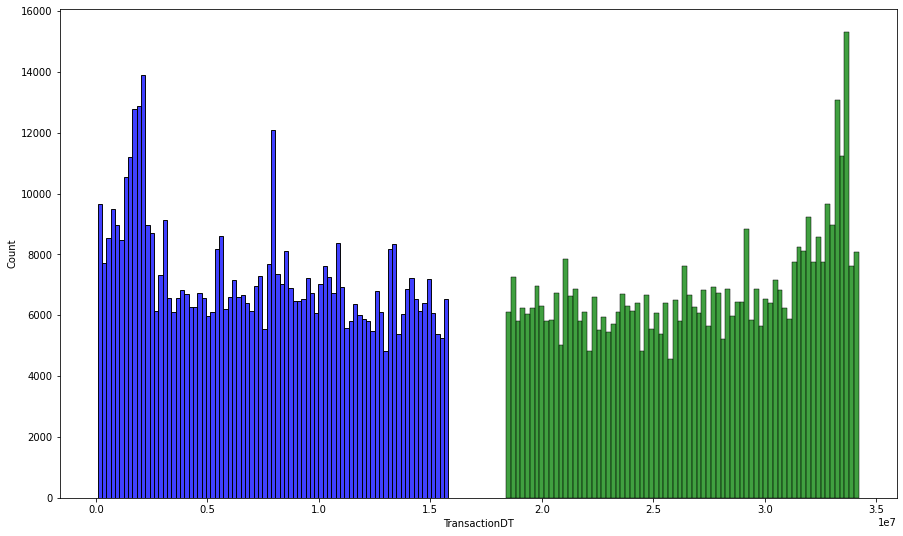

In [80]:
fig, ax = plt.subplots(1,1, figsize = (15,9))
sns.histplot(train.TransactionDT, label = 'Train', kde = False, ax=ax, color = 'blue')
sns.histplot(test.TransactionDT, label = 'Test', kde = False, ax=ax, color = 'green')
plt.show()

In [81]:
# TransactionDT seems to be in seconds from epoch; dont know what epoch is; see below for # of days in train and test
print("Training Dataset length in days: {:.0f}".\
      format((train.TransactionDT.max() - train.TransactionDT.min())/(3600*24)))

print("Test Dataset length in days: {:.0f}".\
      format((test.TransactionDT.max() - test.TransactionDT.min())/(3600*24)))

Training Dataset length in days: 182
Test Dataset length in days: 183


## Feature Engineering

In [37]:
from sklearn.preprocessing import LabelEncoder

In [8]:
def data_massage(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].astype(str).apply(str.upper).str.split('/', expand = True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].astype(str).apply(str.upper).str.split('/', expand = True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('Moto G'.upper(), na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('Moto'.upper(), na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('rv:'.upper(), na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('Linux'.upper(), na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].astype(str).map(str.upper).str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [9]:
train = data_massage(train)
test = data_massage(test)

In [5]:
train['Transaction_day']=np.floor(((train.TransactionDT/(3600*24))-1)%7)
test['Transaction_day']=np.floor(((test.TransactionDT/(3600*24))-1)%7)

In [6]:
train['Transaction_hour']=np.floor((train.TransactionDT/(3600)%24))
test['Transaction_hour']=np.floor((test.TransactionDT/(3600)%24))

In [12]:
train.columns[train.columns.str.contains('Transaction')]

Index(['TransactionID', 'TransactionDT', 'TransactionAmt'], dtype='object')

In [13]:
train['TransactionAmt_ln'] = np.log(train['TransactionAmt'])
test['TransactionAmt_ln'] = np.log(test['TransactionAmt'])

In [19]:
train['TransactionAmt_Decimal'] = ((train.TransactionAmt - train.TransactionAmt.astype(int))*1000).astype(int)
test['TransactionAmt_Decimal'] = ((test.TransactionAmt - test.TransactionAmt.astype(int))*1000).astype(int)

In [21]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [34]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [38]:
# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

# Encoding - count encoding for both train and test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_36']:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

# Encoding - count encoding separately for train and test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [39]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,device_name,device_version,OS_id_30,version_id_30,browser_id_31,version_id_31,screen_width,screen_height,had_id,TransactionAmt_ln,TransactionAmt_Decimal,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,id_02__id_20,id_02__D8,D11__DeviceInfo,DeviceInfo__P_emaildomain,P_emaildomain__C2,card2__dist1,card1__card5,card2__id_20,card5__P_emaildomain,addr1__card1,card1_count_full,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full,id_36_count_full,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 470 entries, TransactionID to id_36_count_dist
dtypes: float64(400), int64(27), object(43)
memory usage: 2.1+ GB


## Memory Usage Reduction

In [ ]:
for col in train.columns[:10]:
  if train[col].dtype != 'object':
    print(col + ': DataType : {}'.format(train[col].dtype))

In [63]:
pd.Series.between(train.id_13.min(), left=np.iinfo(np.int8).min, right=np.iinfo(np.int8).max)
# np.iinfo(np.int8).min

True

In [64]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [65]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 2142.07 MB
Memory usage after optimization is: 599.67 MB
Decreased by 72.0%
Memory usage of dataframe is 1816.90 MB
Memory usage after optimization is: 504.64 MB
Decreased by 72.2%


In [69]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id', ]

In [77]:
set(useful_features) - set(train.columns.values)

set()

In [85]:
# train['Transaction_weekoftheyear']=np.floor((train.TransactionDT/(3600*24*7))%52)
# test['Transaction_weekoftheyear']=np.floor((test.TransactionDT/(3600*24*7))%52)

# train['Transaction_monthoftheyear']=np.floor((test.TransactionDT/(3600*24*365/12))%12)
# test['Transaction_monthoftheyear']=np.floor((test.TransactionDT/(3600*24*365/12))%12)

In [84]:
## Realized the training and test dataset dont overlap for the most part (we 
## might ot have enough transactions to train for ) 

In [7]:
cat_vars = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2',  'P_emaildomain',
       'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9','id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23',
       'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37',
       'id_38', 'DeviceType', 'DeviceInfo','Transaction_day','Transaction_hour']

In [60]:
unique_cats = train.nunique()
unique_cats = pd.DataFrame({'Unique_Cats':train.nunique()})

In [ ]:
pd.set_option('max_rows', 55)
unique_cats.loc[cat_vars]

In [61]:
binary_features = list(unique_cats.loc[cat_vars].loc[unique_cats.loc[cat_vars].Unique_Cats==2].index)

In [62]:
binary_features

['M1',
 'M2',
 'M3',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_16',
 'id_27',
 'id_28',
 'id_29',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType']

In [63]:
test[binary_features].head()

,M1,M2,M3,M5,M6,M7,M8,M9,id_12,id_16,id_27,id_28,id_29,id_35,id_36,id_37,id_38,DeviceType
0,T,T,F,NaN,F,T,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T,F,F,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T,T,F,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,T,T,T,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T,T,T,NaN,F,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
from sklearn.preprocessing import LabelEncoder
label_mapping = pd.DataFrame(columns=['column', 'value', 'coding'])
for bf in binary_features:
  le = LabelEncoder()
  train.loc[:,bf] = train.loc[:,[bf]].astype(str).apply(le.fit_transform)
  test.loc[:,bf] = test.loc[:,[bf]].astype(str).apply(le.transform)
  temp_map = pd.concat((pd.DataFrame([bf]*len(le.classes_), columns=['column']),
           pd.DataFrame(le.classes_, columns=['value']),
           pd.DataFrame(le.transform(le.classes_),columns=['coding'])), axis = 1)
  label_mapping = label_mapping.append(temp_map, ignore_index=True)

In [71]:
for bf in binary_features:
  
  train.loc[train[bf]==2,bf] = -1
  test.loc[test[bf]==2,bf] = -1

In [ ]:
label_mapping.loc[label_mapping.value=='nan']

In [76]:
card1_cnt = pd.DataFrame({'card1':train.card1.value_counts()}).reset_index()
card1_cnt['total'] = len(train.card1.notnull())
card1_cnt['cumsum'] = card1_cnt['card1'].cumsum()
card1_cnt['percent'] = card1_cnt['cumsum'] / card1_cnt['total']
card1_cnt

,index,card1,total,cumsum,percent
0,7919,14932,590540,14932,0.025285
1,9500,14162,590540,29094,0.049267
2,15885,10361,590540,39455,0.066812
3,17188,10344,590540,49799,0.084328
4,15066,7945,590540,57744,0.097782
...,...,...,...,...,...
13548,12390,1,590540,590536,0.999993
13549,10341,1,590540,590537,0.999995
13550,10006,1,590540,590538,0.999997
13551,15743,1,590540,590539,0.999998


In [ ]:
piechart(train, 'card1', 100, 'TransactionID')

In [ ]:
unique_cats.loc[set(cat_vars)-set(binary_features)]

In [ ]:
pd.get_dummies(train.loc[:,cat_vars].astype(str)) # list(set(cat_vars)-set(binary_features))

In [82]:
pd.get_dummies(train.loc[:,['id_14','id_23']].astype('str'))

,id_14_-120.0,id_14_-180.0,id_14_-210.0,id_14_-240.0,id_14_-300.0,id_14_-360.0,id_14_-420.0,id_14_-480.0,id_14_-540.0,id_14_-600.0,id_14_-660.0,id_14_0.0,id_14_120.0,id_14_180.0,id_14_240.0,id_14_270.0,id_14_300.0,id_14_330.0,id_14_360.0,id_14_420.0,id_14_480.0,id_14_540.0,id_14_60.0,id_14_600.0,id_14_720.0,id_14_nan,id_23_IP_PROXY:ANONYMOUS,id_23_IP_PROXY:HIDDEN,id_23_IP_PROXY:TRANSPARENT,id_23_nan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
590536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
590537,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
590538,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [60]:
pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False)

7919     28015
9500     26243
15885    22691
17188    19606
15066    14606
         ...  
14750        1
12703        1
17809        1
3480         1
12204        1
Name: card1, Length: 17091, dtype: int64

In [45]:
len(cat_vars)

51

In [46]:
train.loc[:,cat_vars].head()

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Transaction_day,Transaction_hour
0,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,NaN,T,T,T,M0,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0.0,0.0


In [18]:
pd.get_dummies(train[['M1','M2']])

,M1_F,M1_T,M2_F,M2_T
0,0,1,0,1
1,0,0,0,0
2,0,1,0,1
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
590535,0,1,0,1
590536,0,1,1,0
590537,0,1,1,0
590538,0,1,0,1


In [ ]:
for i in cat_vars:
#     piechart(train, i, 5, 'TransactionID')
    if len(train[i].unique()) <= 10:
        barchart_categorical(train, i, 'isFraud')
    else:
        piechart(train, i, 10, 'TransactionID')

In [ ]:
barchart_categorical(train, 'DeviceType', 'isFraud')

In [ ]:
train.P_emaildomain.unique()

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

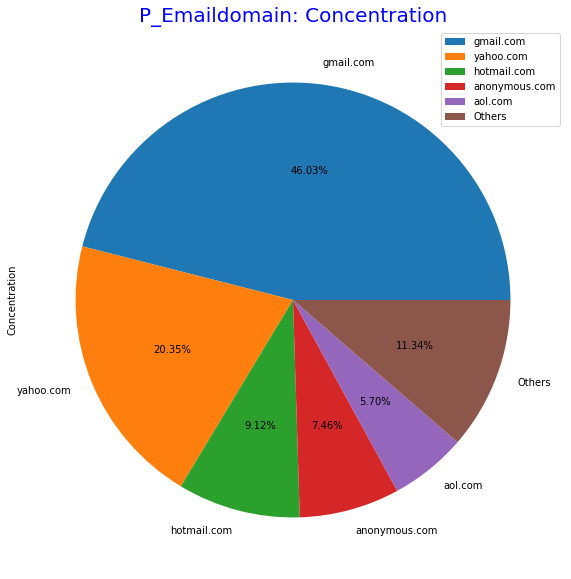

,Count,Concentration
P_emaildomain,,
gmail.com,"228,355",46.03%
yahoo.com,"100,934",20.35%
hotmail.com,"45,250",9.12%
anonymous.com,"36,998",7.46%
aol.com,"28,289",5.70%
Others,"56,258",11.34%


In [ ]:
piechart(train, 'P_emaildomain',5,'TransactionID')

In [32]:
missing_data

,Missing Ratio
id_24,99.196159
id_25,99.130965
id_07,99.127070
id_08,99.127070
id_21,99.126393
...,...
C11,0.000000
C12,0.000000
C13,0.000000
C14,0.000000


In [33]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [ ]:
train['isFraud'].unique()

array([0, 1])

In [ ]:
train_target = train['isFraud']

In [ ]:
train = train.drop(columns=['isFraud'])

In [ ]:
train.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)

In [ ]:
model = XGBClassifier()
model.fit(train, train_target)

ValueError: ignored

In [ ]:
train.dtypes.values

array([dtype('int64'), dtype('int64'), dtype('float64'), dtype('O'),
       dtype('int64'), dtype('float64'), dtype('float64'), dtype('O'),
       dtype('float64'), dtype('O'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('O'), dtype('O'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('O'), dtype('O'),
       dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'),
       dtype('O'), dtype('O'), dtype(